# Higgs Boson Analysis with ATLAS Open Data
This is an example analysis of the Higgs boson detection via the decay channel H &rarr; ZZ* &rarr; 4l  
From the decay products measured at the ATLAS experiment and provided as open data, you will be able to produce a histogram, and from there you can infer the invariant mass of the Higgs boson.  
It is based on the original work at [ATLAS outreach notebooks](https://github.com/atlas-outreach-data-tools/notebooks-collection-opendata/tree/master/13-TeV-examples/uproot_python)  
Data from [ATLAS opendata](http://opendata.atlas.cern/release/2020/documentation/datasets/files.html)  
Reference: ATLAS paper on the [discovery of the Higgs boson](https://www.sciencedirect.com/science/article/pii/S037026931200857X) (mostly Section 4 and 4.1) 

See also: https://github.com/LucaCanali/Miscellaneous/tree/master/Spark_Physics

Author and contact: Luca.Canali@cern.ch  
March, 2022

In [5]:
# Run this if you need to install Apache Spark (PySpark)
# !pip install pyspark

# Install sparkhistogram

!pip install sparkhistogram

In [ ]:
# Run this to download the datasets in Parquet format
# See also https://github.com/LucaCanali/Miscellaneous/tree/master/Spark_Physics

!wget -r -np -R "index.html*" -e robots=off https://sparkdltrigger.web.cern.ch/sparkdltrigger/ATLAS_Higgs_opendata/

## H &rarr; ZZ* &rarr; 4l analysis - with experimental data and Monte Carlo data for signal and background
This roughly reproduces figure 2 of the ATLAS paper on the discovery of the Higgs boson.

In [1]:
# Start the Spark Session
# This uses local mode for simplicity

# the use of findspark is optional
# import findspark
# findspark.init("/home/luca/Spark/spark-3.5.1-bin-hadoop3")

from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .appName("h_zz_llll")
         .master("local[*]")
         .getOrCreate()
        )

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/07 22:54:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Note: if you cannot install the package, create the computeWeightedHistogram
# function as detailed at the end of this notebook.

from sparkhistogram import computeWeightedHistogram

In [3]:
#
# This is where the code for the analysis is defined
# Read data, apply filters and cuts
# Finally compute the 4-lepton invariant mass and compute the histogram
# The output is a pandas dataframe with the histogram data
#
# file_type = "MC" is special, as it is for Monte Carlo data and will compute weights to rescale data
# any other fite_type, in particular "Data" will not use weights
#

def process(file_name, file_type):

    # Read data 
    df_events = spark.read.parquet(file_name)
    
    # Prepare the lepton features used later in processing
    # Prepare the weight for Monte Carlo (MC) data (weight = 1 for experiment data)
    if (file_type == 'MC'):
        df_lep = df_events.selectExpr("""arrays_zip(lep_type, lep_charge, lep_E, lep_pt, lep_phi, lep_eta, lep_z0,
                                         lep_etcone20, lep_ptcone30, lep_trackd0pvunbiased, lep_tracksigd0pvunbiased) lep""",
                                      "10 * 1000 * xsec / (sumw * red_eff) * mcWeight*scaleFactor_PILEUP*scaleFactor_ELE*scaleFactor_MUON*scaleFactor_LepTRIGGER as weight")
    else:
        df_lep = df_events.selectExpr("""arrays_zip(lep_type, lep_charge, lep_E, lep_pt, lep_phi, lep_eta, lep_z0,
                                         lep_etcone20, lep_ptcone30, lep_trackd0pvunbiased, lep_tracksigd0pvunbiased) lep""",
                                      "1.0 as weight")
    
    # filter electrons and muons inside the lepton array
    df_lep_filtered = df_lep.selectExpr("""filter(lep, l ->
                         (l.lep_type = 11
                          and l.lep_pt > 7000.0
                          and abs(l.lep_eta) < 2.4
                          and l.lep_etcone20/l.lep_pt < 0.3
                          and l.lep_ptcone30/l.lep_pt < 0.3
                          and abs(l.lep_trackd0pvunbiased) / l.lep_tracksigd0pvunbiased < 5
                          and l.lep_z0 * sin (2 * atan(exp(-l.lep_eta)))  < 0.5
                         )
                         or 
                         (l.lep_type = 13
                          and l.lep_pt > 5000.0
                          and abs(l.lep_eta) < 2.5
                          and l.lep_etcone20/l.lep_pt < 0.3
                          and l.lep_ptcone30/l.lep_pt < 0.3
                          and abs(l.lep_trackd0pvunbiased) / l.lep_tracksigd0pvunbiased < 3
                          and l.lep_z0 * sin (2 * atan(exp(-l.lep_eta)))  < 0.5
                         )
                       ) as lep""", "weight")
    
    # Apply cuts/filters to the input data
    # only events with 4 leptons in the input data
    df_lep_filtered = df_lep_filtered.filter("size(lep) == 4")
    
    # paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
    # cut on lepton charge
    df_lep_filtered = df_lep_filtered.filter("lep.lep_charge[0] + lep.lep_charge[1] + lep.lep_charge[2] + lep.lep_charge[3] == 0")
    
    # cut on lepton type
    df_lep_filtered = df_lep_filtered.filter("lep.lep_type[0] + lep.lep_type[1] + lep.lep_type[2] + lep.lep_type[3] in (44, 48, 52)")

    # order leptons by pt, highest values first
    df_lep_ordered = df_lep_filtered.selectExpr("""array_sort(lep, (left, right) -> 
        case when left.lep_pt > right.lep_pt then -1 
            when left.lep_pt < right.lep_pt then 1
            else 0 end) as lep""", "weight")
    
    # filter based on the ordered lepton list
    # filter values accoring to the analysis paper

    df_lep_ordered_filtered = df_lep_ordered.filter("""
        lep.lep_pt[0] > 20000.0
        and lep.lep_pt[1] > 15000.0
        and lep.lep_pt[2] > 10000.0
        """)
    
    # Add further cuts on leading and sub-leading lepton pairs here
    # To do...
    
    # This computes the 4-vectors sum for the 4-lepton system
    
    df_4lep = df_lep_filtered.selectExpr(
        "lep.lep_pt[0] * cos(lep.lep_phi[0]) + lep.lep_pt[1] * cos(lep.lep_phi[1]) + lep.lep_pt[2] * cos(lep.lep_phi[2]) + lep.lep_pt[3] * cos(lep.lep_phi[3]) as Px",
        "lep.lep_pt[0] * sin(lep.lep_phi[0]) + lep.lep_pt[1] * sin(lep.lep_phi[1]) + lep.lep_pt[2] * sin(lep.lep_phi[2]) + lep.lep_pt[3] * sin(lep.lep_phi[3]) as Py",
        "lep.lep_pt[0] * sinh(lep.lep_eta[0]) + lep.lep_pt[1] * sinh(lep.lep_eta[1]) + lep.lep_pt[2] * sinh(lep.lep_eta[2]) + lep.lep_pt[3] * sinh(lep.lep_eta[3]) as Pz",
        "lep.lep_E[0] + lep.lep_E[1] + lep.lep_E[2] + lep.lep_E[3] as E", "weight"    
    )
    
    df_4lep_invmass = df_4lep.selectExpr("sqrt(E * E - ( Px * Px + Py * Py + Pz * Pz))/1e3 as invmass_GeV", "weight")

    # This defines the DataFrame transformation to compute the histogram of invariant mass
    # The result is a histogram with (energy) bin values and event counts foreach bin
    # Requires sparkhistogram
    # See https://github.com/LucaCanali/Miscellaneous/blob/master/Spark_Notes/Spark_DataFrame_Histograms.md      
    
    # histogram parameters
    min_val = 80
    max_val = 250
    num_bins = (max_val - min_val) / 5.0

    # use the helper function computeHistogram in the package sparkhistogram
    histogram_data = computeWeightedHistogram(df_4lep_invmass, "invmass_GeV", "abs(weight)", min_val, max_val, num_bins) 
        
    # The action toPandas() here triggers the computation.
    # Histogram data is fetched into the driver as a Pandas Dataframe.
    histogram_data_pandas=histogram_data.toPandas()
    
    return histogram_data_pandas


In [6]:
# Load datasets and run through process, which will apply cuts and create the histogram

# customize depending on how where you downloaded the datasets
data_dir = "./sparkdltrigger.web.cern.ch/sparkdltrigger/ATLAS_Higgs_opendata/"

# Compute the 4-lepton mass spectrum histogram for Monte Carlo signal

signal_MC_file_name = data_dir + "MC_signal_4lep.parquet"
histogram_signal_MC_pandas = process(signal_MC_file_name, "MC")


24/05/07 22:55:55 WARN DAGScheduler: Broadcasting large task binary with size 1044.6 KiB
24/05/07 22:55:56 WARN DAGScheduler: Broadcasting large task binary with size 1050.3 KiB


In [7]:
# Compute the 4-lepton mass spectrum histogram for Monte Carlo background "zz"

background_zz_MC_file_name = data_dir + "MC_background_zz_4lep.parquet"
histogram_background_zz_MC_pandas = process(background_zz_MC_file_name, "MC")


24/05/07 22:56:06 WARN DAGScheduler: Broadcasting large task binary with size 1045.3 KiB
24/05/07 22:56:06 WARN DAGScheduler: Broadcasting large task binary with size 1051.0 KiB


In [8]:
# Compute the 4-lepton mass spectrum histogram for Monte Carlo background "ztt"

background_ztt_MC_file_name = data_dir + "MC_background_ztt_4lep.parquet"
histogram_background_ztt_MC_pandas = process(background_ztt_MC_file_name, "MC")


24/05/07 22:56:07 WARN DAGScheduler: Broadcasting large task binary with size 1045.6 KiB
24/05/07 22:56:08 WARN DAGScheduler: Broadcasting large task binary with size 1051.3 KiB


In [9]:
# Compute the 4-lepton mass spectrum histogram for experimenatal data

data_file_name = data_dir + "Data_4lep.parquet"
histogram_data_pandas = process(data_file_name, "Data")


24/05/07 22:56:09 WARN DAGScheduler: Broadcasting large task binary with size 1040.4 KiB
24/05/07 22:56:09 WARN DAGScheduler: Broadcasting large task binary with size 1045.1 KiB


In [10]:
import numpy as np

# Computes statistical error on the data (histogram)
histogram_data_stat_errors = np.sqrt(histogram_data_pandas)


### Final plot

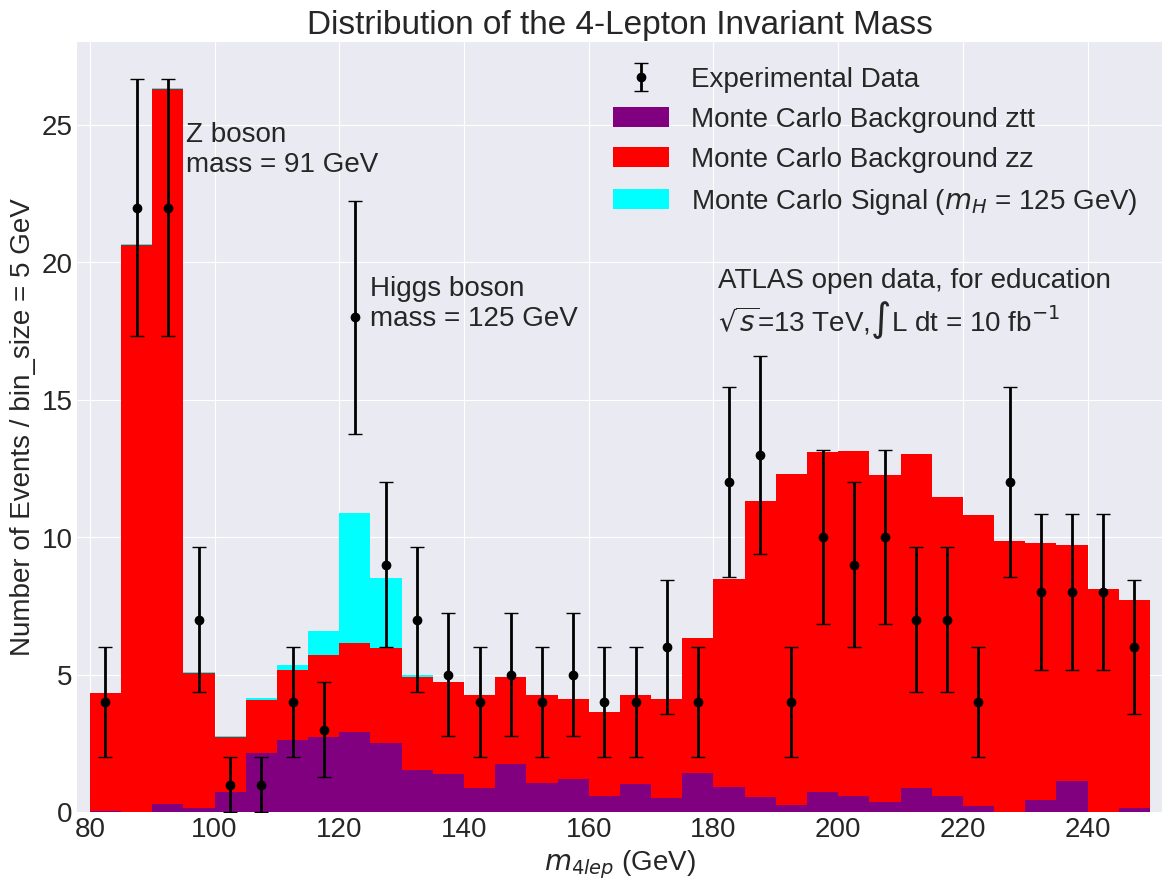

In [11]:
# This plots the data histogram 
# This reproduces (roughly) the Figure 2 of the ATLAS Higgs boson discovery paper
# See https://www.sciencedirect.com/science/article/pii/S037026931200857X

import matplotlib.pyplot as plt 

min_val = 80
max_val = 250
step = 5

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

f, ax = plt.subplots()

x = histogram_data_pandas["value"]
y = histogram_data_pandas["weighted_sum"]
err = histogram_data_stat_errors["weighted_sum"]

# scatter plot for experiment data
#ax.plot(x, y, marker='o', color='black', linewidth=0)
# data histogram with error bars
#ax.bar(x, y, width = 5.0, yerr = data_err, capsize = 5, linewidth = 0.2, ecolor='black', fill=False)
ax.errorbar(x, y, marker='o', linewidth=0, elinewidth=2, yerr=err, color='black', capsize=5,
            label="Experimental Data")

ax.set_xlim(min_val-2, max_val+2)

# Background ztt Monte Carlo data
x = histogram_background_ztt_MC_pandas["value"]
y_ztt = histogram_background_ztt_MC_pandas["weighted_sum"]
ax.bar(x, y_ztt, width = step, capsize = 5, linewidth = 0.4, color='purple', fill=True,
       label="Monte Carlo Background ztt")

# Background zz Monte Carlo data
x = histogram_background_zz_MC_pandas["value"]
y_zz = histogram_background_zz_MC_pandas["weighted_sum"]
ax.bar(x, y_zz, width = 5.0, capsize = 5, linewidth = 0.4, color='red', fill=True, bottom=y_ztt,
       label="Monte Carlo Background zz")


# Signal Monte Carlo data
x = histogram_signal_MC_pandas["value"]
y_signal = histogram_signal_MC_pandas["weighted_sum"]
ax.bar(x, y_signal, width = 5.0, capsize = 5, linewidth = 0.4, color='cyan', fill=True, bottom=y_ztt+y_zz, 
       label="Monte Carlo Signal ($m_H$ = 125 GeV)")
#ax.bar(x, y_signal, width = 5.0, capsize = 5, linewidth = 0.4, color='cyan', fill=True)

# Labels
ax.set_xlabel("$m_{4lep}$ (GeV)")
ax.set_ylabel(f"Number of Events / bin_size = {step} GeV")
ax.set_title("Distribution of the 4-Lepton Invariant Mass")

# Label for the Z ang Higgs spectrum peaks
txt_opts = {'horizontalalignment': 'left',
            'verticalalignment': 'center',
            'transform': ax.transAxes}

plt.text(0.10, 0.86, "Z boson\nmass = 91 GeV", **txt_opts)
plt.text(0.27, 0.66, "Higgs boson\nmass = 125 GeV", **txt_opts)

# Add energy and luminosity
plt.text(0.59, 0.69, "ATLAS open data, for education", **txt_opts)
plt.text(0.59, 0.64, '$\sqrt{s}$=13 TeV,$\int$L dt = 10 fb$^{-1}$', **txt_opts)

ax.legend()

plt.show()

In [12]:
spark.stop()

## Note on sparkhistogram

Use this to define the computeWeightedHistogram function if you cannot pip install sparkhistogram

In [ ]:
from pyspark.sql.functions import sum

def computeWeightedHistogram(df: "DataFrame", value_col: str, weight_col: str,
                             min_val: float, max_val: float, bins: int) -> "DataFrame":
    """ This is a dataframe function to compute the weighted histogram of a DataFrame column.
        A weighted histogram is a generalization of a frequency histogram.

        Parameters
        ----------
        df: the dataframe with the data to compute
        value_col: column name on which to compute the histogram
                   the column needs to be of numeric type
        weight_col: numeric-type column with the weights,
                    the bucket value is computed as sum of weights.
                    If all weight are set to 1, you get a frequency histogram
        min_val: minimum value in the histogram
        max_val: maximum value in the histogram
        bins: number of histogram buckets to compute

        Output DataFrame
        ----------------
        bucket: the bucket number, range from 1 to bins (included)
        value: midpoint value of the given bucket
        weighted_sum: weighted sum of the number of values in the bucket
    """
    # Compute the step size for the histogram
    step = (max_val - min_val) / bins

    # Get the Spark Session handle
    spark = SparkSession.getActiveSession()

    # df_buckets is the range of {bins} buckets as requested by the user
    # It will be used to fill in for missing buckets, i.e. buckets with no corresponding values
    df_buckets = spark.range(bins).selectExpr("id + 1 as bucket")

    # Group user data into buckets and compute a weighted sum of the values
    df_grouped = (df
                  .selectExpr(f"width_bucket({value_col}, {min_val}, {max_val}, {bins}) as bucket", f"{weight_col}")
                  .groupBy("bucket")
                  .agg(sum(f"{weight_col}").alias("weighted_sum"))  # sum the weights on the weight_col
                 )

    # Join df_buckets with the grouped data to fill in missing buckets
    df_hist = (df_buckets # note this will be typically broadcasted, the order of the join is important
               .join(df_grouped, "bucket", "left_outer") # add missing buckets and remove buckets out of range
               .selectExpr("bucket", f"{min_val} + (bucket - 0.5) * {step} as value",  # use center value of the buckets
                           "nvl(weighted_sum, 0) as weighted_sum")  # buckets with no values will have a sum of 0
               .orderBy("bucket")
               )

    return df_hist